In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall xgboost -y
!pip install -U xgboost

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 173.5 MB 74 kB/s 
Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 1.9 MB/s 


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import warnings
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
import joblib
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
import os

In [27]:
basedir = '/content/drive/MyDrive/recidivism/'
raw_datadir = os.path.join(basedir,'data','01_raw')
interim_datadir = os.path.join(basedir,'data','02_interim')
processed_datadir = os.path.join(basedir,'data','03_processed')
modelsdir = os.path.join(basedir,'models/onehot')

In [28]:
xtrain_path = os.path.join(processed_datadir, "Xtrain.csv")
xtest_path = os.path.join(processed_datadir, "Xtest.csv")
ytrain_path = os.path.join(processed_datadir, "ytrain.csv")
ytest_path = os.path.join(processed_datadir, "ytest.csv")

X_train = pd.read_csv(xtrain_path)
X_test = pd.read_csv(xtest_path)
y_train = pd.read_csv(ytrain_path, squeeze=True)
y_test = pd.read_csv(ytest_path, squeeze=True)

print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (19920, 42)
X_test: (4980, 42)
y_train: (19920,)
y_test: (4980,)


In [29]:
columns = ['Age_at_Release',
'Education_Level',
'Dependents',
'Prison_Years',
'Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd',
'Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property',
'Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges',
'Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd',
'Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug',
'Delinquency_Reports',
'Program_Attendances',
'Program_UnexcusedAbsences',
'Residence_Changes',
'Drug_Test_Results',
'Percent_Days_Employed']
result = pd.Series({c: X_train[columns][c].unique() for c in X_train[columns]})
print(result)

Age_at_Release                              [28-32, 38-42, 43-47, 33-37, 23-27, 48 or olde...
Education_Level                             [Less than HS diploma, At least some college, ...
Dependents                                                               [2, 3 or more, 1, 0]
Prison_Years                                [More than 3 years, Less than 1 year, 1-2 year...
Prior_Arrest_Episodes_Felony                       [6, 2, 5, 4, 10 or more, 3, 9, 1, 7, 8, 0]
Prior_Arrest_Episodes_Misd                                      [3, 6 or more, 1, 0, 4, 2, 5]
Prior_Arrest_Episodes_Violent                                            [1, 0, 2, 3 or more]
Prior_Arrest_Episodes_Property                                     [1, 2, 3, 0, 5 or more, 4]
Prior_Arrest_Episodes_Drug                                         [4, 1, 2, 0, 3, 5 or more]
Prior_Arrest_Episodes_PPViolationCharges                           [3, 5 or more, 1, 0, 2, 4]
Prior_Conviction_Episodes_Felony                            

In [30]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']

    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values



## Create imputers
* imputer Avg_Days_per_DrugTest based upon column mean

In [31]:

simpleImputer = SimpleImputer()

## Create Encoders

### One Hot Encoder

In [32]:
oneHot = OneHotEncoder(drop='if_binary')



### Ordinal Encoder

#### Define order for categories and create encoder

In [33]:
ageList = ['18-22','23-27','28-32','33-37','38-42','43-47','48 or older']
education = ['Less than HS diploma','High School Diploma', 'At least some college']
dependents = ['0', '1', '2', '3 or more']
prisonYears = ['Less than 1 year', '1-2 years', 'Greater than 2 to 3 years','More than 3 years']
felony = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9', '10 or more']
misd = ['0','1','2','3','4','5','6 or more']
violent = ['0','1','2', '3 or more']
prop = ['0','1','2','3','4','5 or more']
drug = ['0','1','2','3','4','5 or more']
ppviolation = ['0','1','2','3','4','5 or more']
felony2 = ['0', '1', '2', '3 or more']
misd2 = ['0','1', '2', '3', '4 or more']
prop2 = ['0', '1', '2', '3 or more']
drug2 = ['0','1', '2 or more']
delinquency = ['0' ,'1', '2','3', '4 or more']
attendances = ['0','1','2','3','4','5', '6','7','8','9', '10 or more']
unexcused = ['0', '1', '2', '3 or more']
residence = ['0','1','2', '3 or more']
employment = ['None', 'Less Than Half', 'More Than Half', 'All']
 
ordinalEnc = OrdinalEncoder(categories=[ageList,education,dependents,
                                        prisonYears,felony,misd,violent,prop,drug,
                                        ppviolation,felony2,misd2,prop2,drug2,
                                        delinquency,attendances,unexcused,
                                        residence,employment])

In [34]:
ordlist = ['Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed']

onehotlist = ['Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed',
'Gender','Race','Residence_PUMA','Gang_Affiliated',
'Supervision_Level_First','Prison_Offense','Prior_Arrest_Episodes_DVCharges',
'Prior_Arrest_Episodes_GunCharges','Prior_Conviction_Episodes_Viol',
'Prior_Conviction_Episodes_PPViolationCharges','Prior_Conviction_Episodes_DomesticViolenceCharges',
'Prior_Conviction_Episodes_GunCharges','Prior_Revocations_Parole',
'Prior_Revocations_Probation','Condition_MH_SA','Condition_Cog_Ed',
'Condition_Other','Violations_Instruction',
'Violations_FailToReport','Violations_MoveWithoutPermission',
'Employment_Exempt','Drug_Test_Results']

scalerlist = ['Supervision_Risk_Score_First']

## Define Standard Scaler

In [35]:
scaler = StandardScaler()

## Define Column Transformer for use in models

In [36]:


ct = ColumnTransformer([('oneHot',oneHot,onehotlist),
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

ct2 = ColumnTransformer([
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

# Model Building

## Define function to calculate scores and produce ROC curve
## Define common variables for use in all models

In [37]:
def calc_scores(model,X_test,y_test,estimator_name):
    proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    pos_proba = proba[:,1]
    bs = brier_score_loss(y_test, pos_proba)
    f1 = f1_score(y_test,preds)
    rs = recall_score(y_test,preds)
    ps = precision_score(y_test,preds)
    roc = roc_auc_score(y_test, pos_proba)
    fpr, tpr, thresholds = roc_curve(y_test,preds)
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,estimator_name=estimator_name)
    display = RocCurveDisplay.from_predictions(y_test, pos_proba,name=estimator_name)
    scores = [bs, f1, rs, ps, roc]
    return scores, display

tests = ['Brier Score', 'F1 Score', 'Recall', 'Precision', 'ROC_AUC']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
cv = StratifiedKFold(n_splits=10)

## K-Nearest Neighbors

In [38]:
knn_model = KNeighborsClassifier()

knn_pipeline = Pipeline([("columnTransformer",ct),("knn", knn_model)])


In [39]:
knn_params = {'knn__n_neighbors':[5,10,15,20], 'knn__metric':['minkowski']}


In [40]:
knn_cv = GridSearchCV(knn_pipeline, knn_params, scoring='roc_auc', n_jobs=-1, cv=cv)

In [41]:
knn_cv.fit(X_train,y_train)
joblib.dump(knn_cv.best_estimator_, os.path.join(modelsdir,"model_knn_auc_best.pkl"))
joblib.dump(knn_cv, os.path.join(modelsdir,"model_knn_auc.pkl"))

['/content/drive/MyDrive/recidivism/models/onehot/model_knn_auc.pkl']

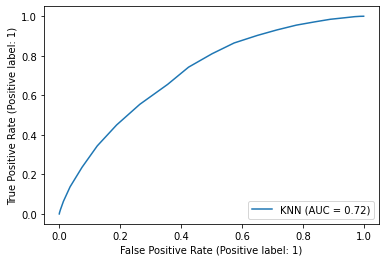

In [42]:
knn_scores, knn_display = calc_scores(knn_cv, X_test, y_test, 'KNN')


In [43]:
print(pd.DataFrame(knn_scores, index=tests, columns=['KNN']))


                  KNN
Brier Score  0.208799
F1 Score     0.727151
Recall       0.742466
Precision    0.712455
ROC_AUC      0.715678


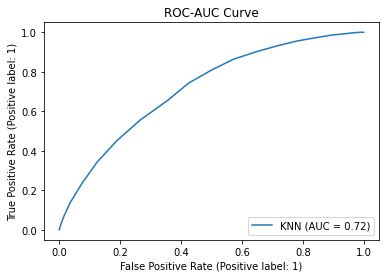

In [44]:
fig, ax = plt.subplots()
knn_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Logistic Regression with Elastic Net Regularization

In [45]:
lr_model = LogisticRegression()

lr_params = {'lr__warm_start': [True, False],'lr__penalty':['elasticnet'],'lr__C':[0.01, 0.05, 0.1, 0.15,0.25, 0.5, 1.0],'lr__solver':['saga'], 'lr__max_iter':[5000], 'lr__l1_ratio':np.linspace(0,1,20,True)}

lr_pipeline = Pipeline([("columnTransformer",ct),("lr", lr_model)])


In [46]:
lr_cv = GridSearchCV(lr_pipeline, lr_params, scoring='roc_auc', n_jobs=-1,cv=cv)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [47]:
joblib.dump(lr_cv.best_estimator_, os.path.join(modelsdir,'model_lr_auc_best.pkl'))
joblib.dump(lr_cv, os.path.join(modelsdir,'model_lr_auc.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_lr_auc.pkl']

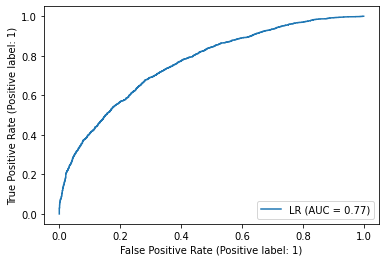

In [48]:
lr_scores, lr_display = calc_scores(lr_cv, X_test, y_test, 'LR')

In [49]:
pd.DataFrame(lr_scores, index=tests, columns=['Logistic Regression'])

,Logistic Regression
Brier Score,0.192259
F1 Score,0.756070
Recall,0.794521
Precision,0.721169
ROC_AUC,0.765119


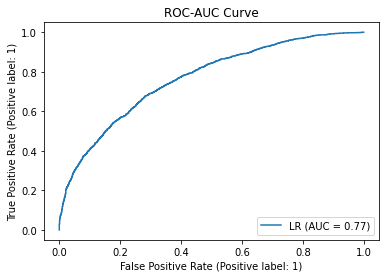

In [50]:
fig, ax = plt.subplots()
lr_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [51]:
lr_cv.best_params_

{'lr__C': 0.15,
 'lr__l1_ratio': 0.9473684210526315,
 'lr__max_iter': 5000,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga',
 'lr__warm_start': True}

In [52]:
lr_cv.best_estimator_['lr'].coef_

array([[ 0.92015307,  0.56022864,  0.17309245,  0.        , -0.13727232,
        -0.34005401, -0.61400085,  0.        ,  0.15865464,  0.        ,
        -0.02532663,  0.00724091,  0.        ,  0.00176244,  0.00989106,
        -0.19912077,  0.27033176, -0.07129541,  0.27770698, -0.47279193,
         0.33541108, -0.19648239, -0.09805269,  0.        , -0.03968834,
         0.01968476, -0.07525936,  0.11301068,  0.13055014, -0.10939845,
        -0.06413248, -0.0223416 ,  0.        ,  0.07485595,  0.        ,
         0.1699037 , -0.0454595 , -0.0362788 ,  0.03085468,  0.03165008,
        -0.07086596, -0.00473621,  0.        ,  0.        ,  0.07807714,
         0.14122106, -0.00883165, -0.01073223,  0.04896871,  0.12974406,
         0.        , -0.03304222, -0.25816518, -0.0940864 ,  0.        ,
         0.00564338,  0.06982171,  0.25521315, -0.0784301 , -0.02752779,
         0.0234039 ,  0.06012175, -0.18497816, -0.00233974,  0.        ,
         0.02724099,  0.14795814,  0.        ,  0. 

## Decision Tree

In [53]:
dt_model = DecisionTreeClassifier()
dt_params = {'dt__criterion':['gini', 'entropy'], 'dt__splitter':['best', 'random']}
dt_pipeline = Pipeline([('columnTransformer', ct),('dt', dt_model)])



In [54]:
dt_cv = GridSearchCV(dt_pipeline, dt_params, scoring='roc_auc', n_jobs=-1, cv=cv)
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [55]:
joblib.dump(dt_cv.best_estimator_, os.path.join(modelsdir,'model_dt_auc_best.pkl'))
joblib.dump(dt_cv, os.path.join(modelsdir,'model_dt_auc.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_dt_auc.pkl']

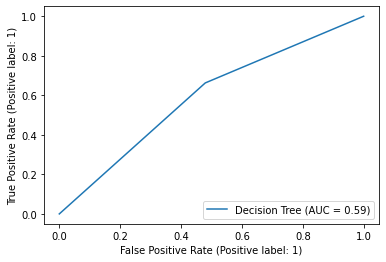

In [56]:
dt_scores, dt_display = calc_scores(dt_cv, X_test, y_test, 'Decision Tree')

In [57]:
pd.DataFrame(dt_scores, index=tests, columns=['Decision Tree'])

,Decision Tree
Brier Score,0.396185
F1 Score,0.662331
Recall,0.662671
Precision,0.661991
ROC_AUC,0.591530


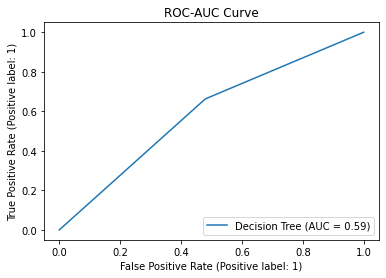

In [58]:
fig, ax = plt.subplots()
dt_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Random Forest

In [59]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[5,10,15,25,50]}
rf_pipeline = Pipeline([('columnTransformer', ct),('rf', rf_model)])



In [60]:
rf_cv = GridSearchCV(rf_pipeline, rf_params, scoring='roc_auc', cv=cv)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [61]:
joblib.dump(rf_cv.best_estimator_, os.path.join(modelsdir,"model_rf_auc_best.pkl"))
joblib.dump(rf_cv, os.path.join(modelsdir,"model_rf_auc.pkl"))

['/content/drive/MyDrive/recidivism/models/onehot/model_rf_auc.pkl']

,Random Forest
Brier Score,0.196493
F1 Score,0.765977
Recall,0.843493
Precision,0.701510
ROC_AUC,0.755890


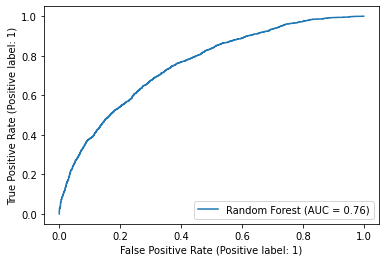

In [62]:
rf_scores, rf_display = calc_scores(rf_cv, X_test, y_test, 'Random Forest')
pd.DataFrame(rf_scores, index=tests, columns=['Random Forest'])

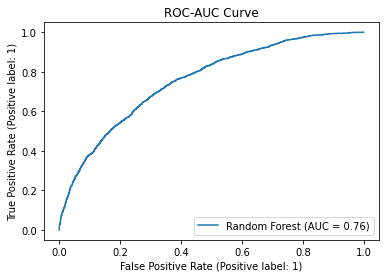

In [63]:
fig, ax = plt.subplots()
rf_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [64]:
rf_cv.best_estimator_

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Age_at_Release',
                                                   'Education_Level',
                                                   'Dependents', 'Prison_Years',
                                                   'Prior_Arrest_Episodes_Felony',
                                                   'Prior_Arrest_Episodes_Misd',
                                                   'Prior_Arrest_Episodes_Violent',
                                                   'Prior_Arrest_Episodes_Property',
                                                   'Prior_Arrest_Episodes_Dru...
                                                   'Prior_Arrest_Episodes_DVCharges',
                                       

## SGD Classifier

In [65]:
sgd_model = SGDClassifier(random_state=42)
sgd_params = {'sgd__loss':['modified_huber','log'], 'sgd__penalty':['elasticnet'], 
              'sgd__alpha':[0.0001,0.001, 0.01, 0.1, 1,10,100], 'sgd__l1_ratio':np.linspace(0,1,10,True)}
sgd_pipeline = Pipeline([('columnTransformer', ct),('sgd', sgd_model)])



In [66]:
sgd_cv = GridSearchCV(sgd_pipeline, sgd_params, scoring='roc_auc', cv=cv)
sgd_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [67]:
joblib.dump(sgd_cv.best_estimator_, os.path.join(modelsdir,'model_sgd_auc_best.pkl'))
joblib.dump(sgd_cv, os.path.join(modelsdir,'model_sgd_auc.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_sgd_auc.pkl']

,SGD
Brier Score,0.192802
F1 Score,0.766924
Recall,0.832192
Precision,0.711150
ROC_AUC,0.765414


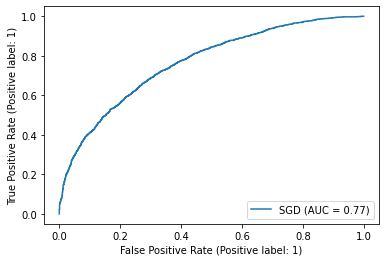

In [68]:
sgd_scores, sgd_display = calc_scores(sgd_cv, X_test, y_test, 'SGD')
pd.DataFrame(sgd_scores, index=tests, columns=['SGD'])

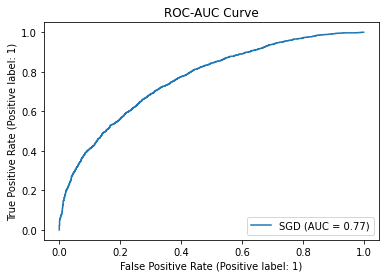

In [69]:
fig, ax = plt.subplots()
sgd_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [70]:
sgd_cv.best_params_

{'sgd__alpha': 0.001,
 'sgd__l1_ratio': 0.3333333333333333,
 'sgd__loss': 'log',
 'sgd__penalty': 'elasticnet'}

## XGBoost Model


In [71]:
xgb_params_old = {
    'xgb__eta': [0.3], 
    'xgb__max_depth': [5],  
    'xgb__objective': ['multi:softprob'],  
    'xgb__num_class': [2],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'xgb__colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'xgb__eval_metric':['merror']} 

xgb_params = {
    'xgb__booster': ['gbtree'],
    'xgb__eta': [.0001, .0005, .001, .005, .01, .05, .1, .5, .75], 
    'xgb__max_depth': [3, 6, 8, 10, 12, 15],  
    'xgb__objective': ['multi:softprob'],  
    'xgb__num_class': [2],
    'xgb__subsample': [0.5, 0.75, 1],
    'xgb__tree_method': ['auto', 'hist'],
    'xgb__eval_metric':['merror'], 
    'xgb__min_child_weights': [1, 5, 10],
    'xgb__max_delta_step': [1, 5, 10]} 



xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_pipeline = Pipeline([('columnTransformer', ct),('xgb', xgb_model)])
xgb_cv = RandomizedSearchCV(xgb_pipeline, xgb_params, scoring='roc_auc', cv=cv)



In [72]:
xgb_cv.fit(X_train,y_train)

[20:28:47] WARNING: ../src/learner.cc:576: 
Parameters: { "min_child_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:28:50] WARNING: ../src/learner.cc:576: 
Parameters: { "min_child_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:28:53] WARNING: ../src/learner.cc:576: 
Parameters: { "min_child_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter act

KeyboardInterrupt: ignored

In [ ]:
joblib.dump(xgb_cv.best_estimator_, os.path.join(modelsdir,'model_xgb_auc_best.pkl'))
joblib.dump(xgb_cv, os.path.join(modelsdir,'model_xgb_auc.pkl'))
# xgb_cv.best_estimator_.save_model(os.path.join(modelsdir,'model_xgb2.pkl'))

In [ ]:
xgb_cv.predict_proba(X_test)

In [ ]:
xgb_scores, xgb_display = calc_scores(xgb_cv, X_test, y_test, 'XGB')
pd.DataFrame(xgb_scores, index=tests, columns=['XGB'])

Fit column transformer to data to obtain column names

In [ ]:
import sklearn
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
# feature_cols = get_feature_names(lr_pipeline['columnTransformer'])
lr_coef = lr_cv.best_estimator_['lr'].coef_